In [14]:
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
from PyEMD import EMD
from PyEMD import EEMD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
num_class = 12
close_num = 12
batch_size = 64
learning_rate = 0.001
num_epochs = 300
sequence_len = 1000 * 5 # sampling_rate * second
overlap = int(sequence_len * 0.3)
alpha = 0.1

In [4]:
data_list = []
scaler = MinMaxScaler((0, 1))
scaler = StandardScaler()

for i in range(1, num_class + 1):
    file_path_fil = "./data/BPF/filterd%02d.csv" % i
    file_path_unfil = "./data/BPF/unfilterd%02d.csv" % i
    data_unfil = pd.read_csv(file_path_unfil)
    scaler.fit(data_unfil) # normalize data
    data_unfil_norm = scaler.transform(data_unfil)
    data_np_unfil_norm = data_unfil_norm.flatten()
    data_np_unfil_norm = data_np_unfil_norm[:899999] # データ数を揃える
    if i == 1:
        data_np_unfil_ID1 = data_np_unfil_norm[:899999]
    # df_fil = pd.DataFrame(data_fil)
    # data_unfil = pd.read_csv(file_path_unfil)
    # df_unfil = pd.DataFrame(data_unfil)

    end = len(data_np_unfil_norm)
    n = 0
    n_stop = sequence_len
    data_segs = []
    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = data_np_unfil_norm[n_start:n_stop].copy()
        data_segs.append([seg])
        n += 1

    data_list.append(data_segs)

In [33]:
s.shape

(9000,)

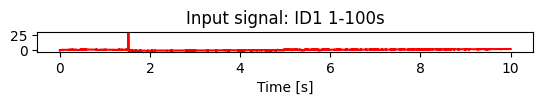

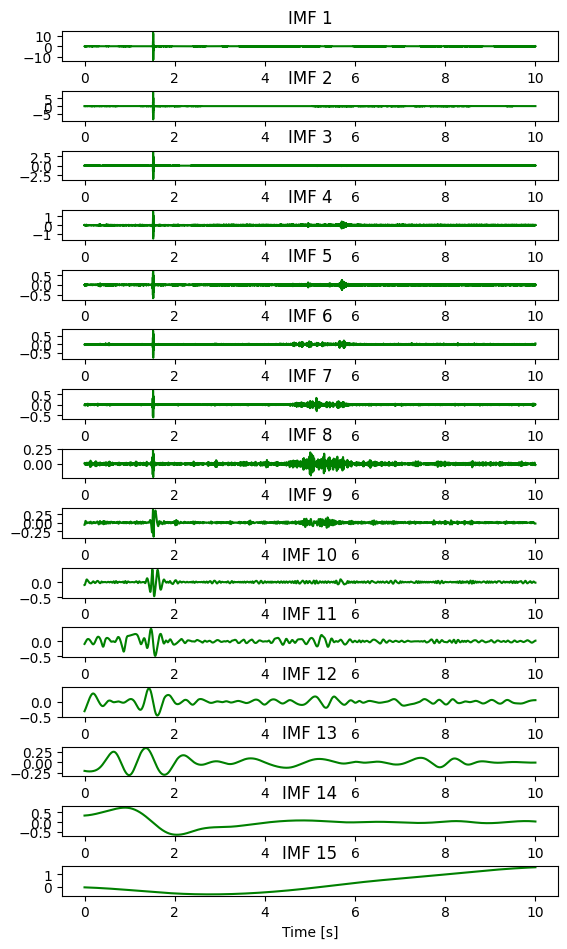

In [12]:
t = np.linspace(0, 10, 100000-1000)
s = data_np_unfil_ID1[1000:100000]
IMF = EMD().emd(s, t)
N = IMF.shape[0] + 1

plt.subplot(N, 1, 1)
plt.plot(t, s, 'r')
plt.title("Input signal: ID1 1-100s")
plt.xlabel("Time [s]")
plt.figure(figsize=(6.4, 12))
plt.subplots_adjust(hspace=1.0)

for n, imf in enumerate(IMF):
    plt.subplot(N, 1, n + 2)
    plt.plot(t, imf, 'g')
    plt.title("IMF " + str(n + 1))
    plt.xlabel("Time [s]")
plt.savefig("emd_example")
plt.show()

In [30]:
t = np.linspace(1, 900, 900000-1001)
s = data_np_fil_ID1[1000:]
eemd = EEMD()
emd = eemd.EMD
emd.extrema_detection = "parabol"
eIMFs = eemd.eemd(s, t)
nIMFs = eIMFs.shape[0]

plt.figure(figsize=(6.4, 10))
plt.subplot(nIMFs + 1, 1, 1)
plt.plot(t, s, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMFs %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
plt.xlabel("Time [s]")
# plt.savefig('eemd_example', dpi=120)
plt.show()

/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:590: RuntimeWarning: divide by zero encountered in divide
  a = a / scale
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:591: RuntimeWarning: divide by zero encountered in divide
  b = b / scale
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:592: RuntimeWarning: divide by zero encountered in divide
  c = c / scale
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:594: RuntimeWarning: invalid value encountered in divide
  tVertex = -0.5 * b / a
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:590: RuntimeWarning: invalid value encountered in divide
  a = a / scale
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/PyEMD/EMD.py:592: RuntimeWarning: in

ValueError: operands could not be broadcast together with shapes (898999,) (896850,) 

In [ ]:
t = np.linspace(1, 10, 9000)
s = data_np_fil_ID1
eemd = EEMD()
emd = eemd.EMD
emd.extrema_detection = "parabol"
eIMFs = eemd.eemd(s, t)
nIMFs = eIMFs.shape[0]

plt.figure(figsize=(6.4, 10))
plt.subplot(nIMFs + 1, 1, 1)
plt.plot(t, s, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMFs %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
plt.xlabel("Time [s]")
plt.savefig('eemd_all', dpi=120)
plt.show()

In [13]:
def segmentation(end_idx, sequence_len, overlap, data_list):
    """
    データのセグメンテーションを行う
    segmentation(len(data_np_unfil_norm), sequence_len, overlap, data_list)
    """
    seg_list = []

    for data in data_list:
        n = 0
        n_stop = sequence_len
        data_segs = []
        while n_stop < end_idx:
            n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
            n_stop = n_start + sequence_len
            seg = data[n_start:n_stop].copy()
            if len(seg) == 5000:
                data_segs.append([seg])
            n += 1
        seg_list.append(data_segs)
    return seg_list

In [17]:
data_list = []
seg_list = []

scaler = MinMaxScaler((0, 1))
scaler = StandardScaler()

for i in range(1, num_class + 1):
    # file_path = "./data/BPF/filterd%02d.csv" % i
    # file_path = "./data/BPF/unfilterd%02d.csv" % i
    file_path = "./data/Keio Hospital/I_raw_%02d.csv" % i
    data_unfil = pd.read_csv(file_path)
    scaler.fit(data_unfil) # normalize data
    data_unfil_norm = scaler.transform(data_unfil)
    data_np_unfil_norm = data_unfil_norm.flatten()
    data_np_unfil_norm = data_np_unfil_norm[:899999] # データ数を揃える

    data_list.append(data_np_unfil_norm) # data_list idx:0~close_num-1
    if i == 1:
        data_np_unfil_ID1 = data_np_unfil_norm[:899999]
    # df_fil = pd.DataFrame(data_fil)
    # data_unfil = pd.read_csv(file_path_unfil)
    # df_unfil = pd.DataFrame(data_unfil)

seg_list = segmentation(len(data_np_unfil_norm), sequence_len, overlap, data_list)
    # segmentationで置き換えた
    # end = len(data_np_unfil_norm)
    # n = 0
    # n_stop = sequence_len
    # data_segs = []
    # while n_stop < end:
    #     n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
    #     n_stop = n_start + sequence_len
    #     tmp = []
    #     seg = data_np_unfil_norm[n_start:n_stop].copy()
    #     data_segs.append([seg])
    #     n += 1

    # data_list.append(data_segs)

In [27]:
labels = []
for i in range(len(seg_list)):
    for j in range(len(seg_list[i])):
        if i <= close_num:
            labels.append(i)
            labels.append(i)
            labels.append(i)
        else:
            labels.append(close_num + 1) # for open set
            labels.append(close_num + 1)
            labels.append(close_num + 1)

In [ ]:
labels